#RL Tutorial 

<a href="https://colab.research.google.com/github/eemlcommunity/PracticalSessions2022/blob/master/rl/EEML2022_RL_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contact us at feryal@google.com & gcomanici@google.com for any questions/comments :)

Special thanks to Anita Gergely and Bobak Shahriari.





The tutorial covers a number of important reinforcement learning (RL) algorithms, including policy iteration, Q-Learning, and Neural Fitted Q. In the first part, we will guide you through the general interaction between RL agents and environments, where the agents ought to take actions in order to maximize returns (i.e. cumulative reward). Next, we will implement Policy Iteration, SARSA, and Q-Learning for a simple tabular environment. The core ideas in the latter will be scaled to more complex MDPs through the use of function approximation. Lastly, we will provide a short introduction to deep reinforcement learning and the DQN algorithm.


# Overview

The agent interacts with the environment in a loop corresponding to the following diagram. The environment defines a set of <font color='blue'>**actions**</font>  that an agent can take.  The agent takes an action informed by the <font color='red'>**observations**</font> it recieves, and will get a <font color='green'>**reward**</font> from the environment after each action. The goal in RL is to find an agent whose actions maximize the total accumulation of rewards obtained from the environment. 


<center><img src="https://drive.google.com/uc?id=1sVOD2Ux5F_1Yq3KjyLOKFjFm2WRNTbIH" width="500" /></center>

The tutorial is mainly focused on **value based methods**: agents are maintaining a value for all state-action pairs and use those estimates to choose actions that maximize that value (instead of maintaining a policy directly, like in policy gradient methods). 

We represent the action-value function (otherwise known as Q-function) associated with following/employing a policy $\pi$ in a given MDP as:

$$ Q^{\pi}(\color{red}{s},\color{blue}{a}) = \mathbb{E}_{\tau \sim P^{\pi}} \left[ \sum_t \gamma^t \color{green}{R_t}| s_0=\color{red}s,a=\color{blue}{a_0} \right]$$

where $\tau = \{\color{red}{s_0}, \color{blue}{a_0}, \color{green}{r_0}, \color{red}{s_1}, \color{blue}{a_1}, \color{green}{r_1}, \cdots \}$

Recall that efficient value estimations are based on the famous **_Bellman Optimallity Equation_**:

$$ Q^\pi(\color{red}{s},\color{blue}{a}) =  \color{green}{r}(\color{red}{s},\color{blue}{a}) + \gamma  \sum_{\color{red}{s'}\in \color{red}{\mathcal{S}}} P(\color{red}{s'} |\color{red}{s},\color{blue}{a}) V^\pi(\color{red}{s'}) $$

where $V^\pi$ is the expected $Q^\pi$ value for a particular state, i.e. $V^\pi(\color{red}{s}) = \sum_{\color{blue}{a} \in \color{blue}{\mathcal{A}}} \pi(\color{blue}{a} |\color{red}{s}) Q^\pi(\color{red}{s},\color{blue}{a})$.

## Installation

### Install required libraries

1. [Acme](https://github.com/deepmind/acme) is a library of reinforcement learning (RL) agents and agent building blocks. Acme strives to expose simple, efficient, and readable agents, that serve both as reference implementations of popular algorithms and as strong baselines, while still providing enough flexibility to do novel research. The design of Acme also attempts to provide multiple points of entry to the RL problem at differing levels of complexity.


2. [Haiku](https://github.com/deepmind/dm-haiku) is a simple neural network library for JAX developed by some of the authors of Sonnet, a neural network library for TensorFlow.

3. [dm_env](https://github.com/deepmind/dm_env): DeepMind Environment API, which will be covered in more details in the [Environment subsection](https://colab.research.google.com/drive/1oKyyhOFAFSBTpVnmuOm9HXh5D5ekqhh5#scrollTo=I6KuVGSk4uc9) below.

In [53]:
#@title Installations  { form-width: "30%" }

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!sudo apt-get install -y xvfb ffmpeg
!pip install imageio

from IPython.display import clear_output
clear_output()

## Import Modules

In [54]:
#@title Imports  { form-width: "30%" }
%matplotlib inline

import IPython

import acme
from acme import environment_loop
from acme import datasets
from acme import specs
from acme import wrappers
from acme.wrappers import gym_wrapper
from acme.agents.jax import dqn
from acme.adders import reverb as adders
from acme.utils import counting
from acme.utils import loggers
import base64
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import io
import imageio
import itertools
import jax
from jax import tree_util
# from jax.experimental import optix
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=1)

plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

# RL Lab - Part 0: Environment & Agent

## Environment



We will focus on a simple grid world environment for this practical session. 


<img src="https://drive.google.com/uc?id=1qBjh_PRdZ4GWTDqB9pmjLEOlUAsOfrZi" width="500" />



This environment consists of either walls and empty cells. The agent starts from an initial location and needs to navigate to reach a goal location. 


In [3]:
#@title Gridworld Implementation { form-width: "30%" }


class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    """Build a grid environment.

    Simple gridworld defined by a map layout, a start and a goal state.

    Layout should be a NxN grid, containing:
      * 0: empty
      * -1: wall
      * Any other positive value: value indicates reward; episode will terminate

    Args:
      layout: NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple (y, x) of starting location.
      goal_state: Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the 
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels. 
          First channel contains walls (1 if wall, 0 otherwise), second the 
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with 
          (agent_y, agent_x, goal_y, goal_x)
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      reward_goal: Reward added when finding the goal (should be positive).
      max_episode_length: If set, will terminate an episode after this many 
        steps.
      randomize_goals: If true, randomize goal at every episode.
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state

  def set_state(self, x, y):
    self._state = (y, x)

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)

  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)


def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Construct a particular Gridworld layout with start/goal states.

  Args:
      task: string name of the task to use. One of {'simple', 'obstacle', 
        'random_goal'}.
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the 
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels. 
          First channel contains walls (1 if wall, 0 otherwise), second the 
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with 
          (agent_y, agent_x, goal_y, goal_x).
      max_episode_length: If set, will terminate an episode after this many 
        steps.
  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle to avoid.

You can visualize the grid worlds by running the cell below. 

Note that `S` indicates the start state and `G` indicates the goal. 


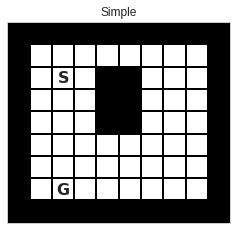

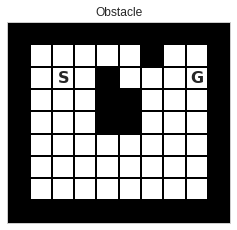

In [4]:
# @title Visualise gridworlds { form-width: "30%" }

# Instantiate two tabular environments, a simple task, and one that involves
# the avoidance of an obstacle.
simple_grid = build_gridworld_task(
    task='simple', observation_type=ObservationType.GRID)
obstacle_grid = build_gridworld_task(
    task='obstacle', observation_type=ObservationType.GRID)

# Plot them.
simple_grid.plot_grid()
plt.title('Simple')

obstacle_grid.plot_grid()
plt.title('Obstacle');

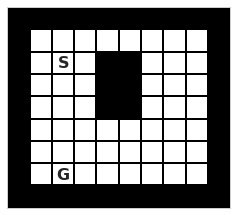

In [5]:
simple_grid.plot_grid()


In this environment, the agent has four possible  <font color='blue'>**Actions**</font>: `up`, `right`, `down`, and `left`.  <font color='green'>**Reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. **Discount** on continuing steps, is $\gamma = 0.9$. 

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g. observations) or consumes (e.g. actions). The `environment_spec` will show you the form of the *observations*, *rewards* and *discounts* that the environment exposes and the form of the *actions* that can be taken.


In [6]:
environment, environment_spec = setup_environment(simple_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 




We first set the environment to its initial location by calling the `reset` method which returns the first observation. 


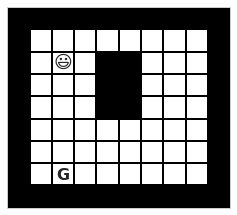

In [7]:
environment.reset()
environment.plot_state()

Now we want to take an action using the `step` method to interact with the environment which returns a `TimeStep` 
namedtuple with fields:

```none
step_type, reward, discount, observation
``` 

We can then visualise the updated state of the grid. 

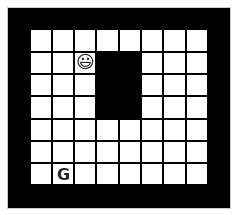

In [8]:
timestep = environment.step(1)
environment.plot_state()

## Agent

We will be implementing Tabular & Function Approximation agents. Tabular agents are purely in Python while for Function Approximation agents, we will use JAX.

### Agent Implementation

Each agent implements the following functions:



> `__init__(self, number_of_actions, number_of_states, ...)`


The constructor will provide the agent the number of actions and number of
states.

> `select_action(self, observation)`:

This is the policy used by the actor to interact with the environment.

> `observe_first(self, timestep)`:

This function provides the agent with initial timestep in a given episode. Note
that this is not the result of an action choice by the agent, hence it will only
have `timestep.observation` set to a proper value.

> `observe(self, action, next_timestep)`:

This function provides the agent with the timestep that resulted from the given
action choice. The timestep provides a `reward`, a `discount`, and an
`observation`, all results of the previous action choice.

> `update(self)`:

This function commonly implements the update rules for the internal parameters of the agent (e.g. Q-values, network parameters for value or policy models, transition models).


Note: `timestep.step_type` will be either `MID` or `LAST` and should be used to
determine whether this is the last observation in the episode.


In [9]:
#@title Example: Random Agent  { form-width: "30%" }

# Uniform random policy
def random_policy(q):
  return np.random.randint(4)

# (Do not worry about the details here, we will explain the Actor class below)
class RandomAgent(acme.Actor):
  def select_action(self, observation):
    return random_policy(None)    
    
  def observe_first(self, timestep):
    """The agent is being notified that environment was reset."""
    pass

  def observe(self, action, next_timestep):
    """The agent is being notified of an environment step."""
    pass

  def update(self):    
    """Agent should update its parameters."""
    pass

## Environment loops

Environment loops are where agent-environment interaction is facilitated. Below we define a loop which repeatedly prompts the agent to select an action and forwards that to the environment. Meanwhile, the agent also makes updates and gradually learns to solve the task.

In [10]:
#@title Run loop  { form-width: "30%" }


def run_loop(environment,
             agent,
             num_episodes=None,
             num_steps=None,
             logger_time_delta=1.,
             label='training_loop',
             log_loss=False,
             ):
  """Perform the run loop.

  We are following the Acme run loop.

  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env used to generate trajectories.
    agent: acme.Actor for selecting actions in the run loop.
    num_steps: number of episodes to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: number of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: time interval (in seconds) between consecutive logging
      steps.
    label: optional label used at logging steps.
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []
  
  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()
    
    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss/episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)
    
    if num_steps is not None and num_total_steps >= num_steps:
      break
  return all_returns

In [11]:
#@title Evaluation loop { form-width: "30%" }

def evaluate(environment, agent, evaluation_episodes):
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames, filename='temp.mp4', frame_repeat=1):
  """Save and display video."""
  # Write video
  with imageio.get_writer(filename, fps=60) as video:
    for frame in frames:
      for _ in range(frame_repeat):
        video.append_data(frame)
  # Read video and display the video
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)

In [55]:
! pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's use these loops to run a Random Agent on our environment!

In [14]:
#@title Visualise random agent's behaviour { form-width: "30%" }

# This is how the random policy moves around
frames = evaluate(environment, RandomAgent(), evaluation_episodes=1)
display_video(frames, frame_repeat=5)

Episode 0 ended with reward -125.0 in 118 steps


# RL Lab - Part 1: Tabular Agents

The first set of execises are based on the simpler case where the number of states is small enough for our agents to maintain a table of values for each state-action pair that it will ever encounter. For example, in the case of GridWorld, such a table may look something like this:

| (State, Action) | Q-value  |
| ----------------| ---------|
| ($s_i$, up)     | 0.7      |
| ($s_i$, down)   | 0.0      |
| ($s_i$, left)   | -0.5     |
| ($s_i$, right)  | 0.32     |
| ($s_j$, up)     | -1.0     |
| ($s_j$, down)   | 0.1      |
| $\dots$         | $\dots$  |

Or in a more compact representation:

| Q(s,a)  | up        | down      | left      | right     |
| ------- | --------- | --------- | --------- | --------- |
| $s_i$   | 0.7       | 0.0       | -0.5      | 0.32      |
| $s_j$   | -1.0      | 0.1       | 0.2       | 0.3       |
| $s_k$   | 0.4       | 0.15      | 0.6       | -0.23     |
| $\dots$ | $\dots$   | $\dots$   | $\dots$   | $\dots$   |



In the exercises below, we will consider the case where the GridWorld has a fixed layout, and the goal is always at the same location, hence the state is fully determined by the location of the agent. As such, the <font color='red'>observation</font> from the environment is changed to be an integer corresponding to each one of approximately 50 locations on the grid.


In [15]:
# Environment
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.STATE_INDEX,
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)


## 1.0: Overview

We will cover three basic RL tabular algorithms:
- Policy iteration
- SARSA Agent
- Q-learning Agent






### (Recap) Bellman equations

============================================

*Bellman Expectation Equation* \\
$$ Q^{\pi}(s,a) = r(s,a) + \gamma \mathbb{E}_{s',a' \sim \pi} [Q^{\pi}(s',a')]$$

(Turn this into an update => policy evaluation)

$$ \tilde{Q}^\pi(\color{red}{s},\color{blue}{a}) ←  \color{green}{r}(\color{red}{s},\color{blue}{a}) + \gamma \tilde{Q}^\pi(\color{red}{s'},\color{blue}{a'})$$

=============================================


*Bellman Optimality Equation* \\

$$ Q^*(s,a) = r(s,a) + \gamma \mathbb{E}_{s'} [\max_{a'}Q^*(s',a')]$$

where $Q^* = \max_{\pi} Q^{\pi}$ is the optimal value function.

(Turn this into an update => Q-learning)

$$ \tilde{Q}^*(\color{red}{s},\color{blue}{a}) ←  \color{green}{r}(\color{red}{s},\color{blue}{a}) + \gamma \max_{\color{blue}{a'}}\tilde{Q}^*(\color{red}{s'},\color{blue}{a'})$$





### TD-error

Initially, we do not have good estimates of the $Q^\pi$ values, so they do not satisfy this intuition. During training, we iteratively make updates to our $Q^\pi$ estimates such that they are a bit closer to satisfying this relationship. Theory tells us that these updates will eventually converge to the optimal solution, i.e. our $Q^\pi$ estimates will satisfy exactly the relationship.

So how do we do this in practice? 
This difference between what $Q^\pi$ *currently is* and what we *want it to be* is called **TD-error**, which, in the long term, we hope will converge to 0.

To make our updates, in every step will we want to compute the TD-error

$$\delta = \color{green}{r}(\color{red}{s},\color{blue}{a}) + \gamma Q^\pi(\color{red}{s'},\color{blue}{a'}) - Q^\pi(\color{red}{s},\color{blue}{a})$$

Then we can use this TD-error to update $Q^\pi$:

$$Q^\pi(\color{red}{s},\color{blue}{a}) \mathrel{{+}{=}} \alpha (\color{green}{r}(\color{red}{s},\color{blue}{a}) + \gamma Q^\pi(\color{red}{s'},\color{blue}{a'}) - Q^\pi(\color{red}{s},\color{blue}{a}))$$

where $\alpha$ is parameter capturing the step size.

We see two immediate questions here.
 * How do we choose $\color{blue}{a}$? $\rightarrow$ behaviour policy $\pi_b$
 * How do we define the "next" action $\color{blue}{a'}$? $\rightarrow$ evaluated policy $\pi_e$


## 1.1: Policy iteration

The first RL learning algorithm we will explore is **policy iteration**, which is repeating (1) Policy Evaluation and (2) Greedy Improvement until convergence.

<center><img src="https://drive.google.com/uc?id=1lP2dFEXCBgYW744S3Lr3zMzVfOEYowdJ" width="300" /></center>

For this exercise, we'll show you how to implement the "first 2 arrows", we will not repeat these steps to convergence yet.

### 1. Policy Evaluation 

The purpose here is to evaluate a given policy $\pi_e$:

Compute the value function associated with following/employing this policy in a given MDP.

$$ Q^{\pi_e}(\color{red}{s},\color{blue}{a}) = \mathbb{E}_{\tau \sim P^{\pi_b}} \left[ \sum_t \gamma^t \color{green}{R_t}| s_0=\color{red}s,a=\color{blue}{a_0} \right]$$

where $\tau = \{\color{red}{s_0}, \color{blue}{a_0}, \color{green}{r_0}, \color{red}{s_1}, \color{blue}{a_1}, \color{green}{r_1}, \cdots \}$ and $\pi_e = \pi_b$ (on-policy evaluation).


Algorithm:

**Initialize** $Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}$

**Loop forever**:

1. $\color{red}{s} \gets{}$current (nonterminal) state
 
2. $\color{blue}{a} \gets{} \text{behaviour_policy }a \sim \pi_b(\color{red}s)=\pi_e(\color{red}s)$
 
3. Take action $\color{blue}{a}$; observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

4. Compute TD-error: $\delta = \color{green}R + \gamma Q(\color{red}{s'}, \underbrace{\pi_e(\color{red}{s'}}_{\color{blue}{a'}})) − Q(\color{red}s, \color{blue}a)$

4. Update Q-value with a small $\alpha$ step: $Q(\color{red}s, \color{blue}a) \gets Q(\color{red}s, \color{blue}a) + \alpha \delta$

### 2. Greedy Policy Improvement

Once a good approximation to the Q-value of a policy is obtained, we can improve this policy by simply changing action selection towards those that are evaluated higher. 

$$ \pi_{greedy} (\color{blue}a|\color{red}s) = \arg\max_\color{blue}a Q^{\pi_e}(\color{red}s,\color{blue}a) $$

### Create a policy evaluation agent

An ACME `Actor` is the part of our framework that directly interacts with an environment by generating actions. Here we borrow a figure from Acme to show how this interaction occurs:

<center><img src="https://drive.google.com/uc?id=1T7FTpA9RgDYFkciDFZK4brNyURZN_ZGp" width="500" /></center>

While you can always write your own actor, we also provide a number of useful premade versions. 

Tabular agents implement a function `q_values()` returning a matrix of Q values
of shape: (`number_of_states`, `number_of_actions`)

In this section, we will implement a `PolicyEvalAgent` as an ACME actor: given an `evaluation_policy` and a `behaviour_policy`, it will use the `behaviour_policy` to choose actions, and it will use the corresponding trajectory data to evaluate the `evaluation_policy` (i.e. compute the Q-values as if you were following the `evaluation_policy`).

In [16]:
#@title **[Coding Task]** Policy Evaluation Agent { form-width: "30%" }
class PolicyEvalAgent(acme.Actor):

  def __init__(
      self, 
      number_of_states, 
      number_of_actions,
      evaluated_policy, 
      behaviour_policy=random_policy, 
      step_size=0.1):
    self._state = None
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    
    # ============ YOUR CODE HERE =============
    # initialize your q-values (this is a table of state and action pairs
    # Note: this can be random, but the code was tested w/ zero-initialization 
    pass
    
  @property
  def q_values(self):
    # ============ YOUR CODE HERE =============
    pass

  def select_action(self, observation):
    # ============ YOUR CODE HERE =============
    pass
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # ============ YOUR CODE HERE =============
    # Compute TD-Error.
    # self._td_error =
    pass

  def update(self):    
    # ============ YOUR CODE HERE =============
    # Q-value table update.
    pass

In [17]:
#@title **[Solution]** Policy Evaluation Agent{ form-width: "30%" }
class PolicyEvalAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, 
      evaluated_policy, 
      behaviour_policy=random_policy, 
      step_size=0.1):
    self._state = None
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    
    self._q = np.zeros((number_of_states, number_of_actions))
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # Compute TD-Error.
    self._action = a
    self._next_state = next_s
    
    next_a = self._evaluated_policy(self._q[next_s])
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]
    
    
  def update(self):
    # Q-value table update.
    s = self._state
    a = self._action
    self._q[s, a] += self._step_size * self._td_error
    self._state = self._next_state

In [18]:
#@title Helper functions for visualisation  { form-width: "30%" }

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      

def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  
def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

We will first see how this works on the `simple` GridWorld task.

**Task 1**: Run the policy evaluation agent, evaluating the uniformly random policy on the `simple` task.

Try different number of training steps, e.g. $\texttt{num_steps} = 1e3, 1e5$. 

Visualise the resulting value functions $Q(\color{red}s,\color{blue}a)$.
The plotting function is provided for you and it takes in a table of q-values.

AFTER 100000.0 STEPS ...


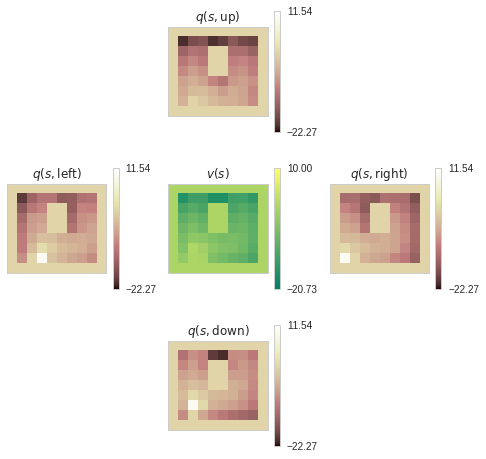

In [19]:
num_steps = 1e5  #@param {type:"number"}

# environment
grid = build_gridworld_task(task='simple')
environment, environment_spec = setup_environment(grid)

# agent 
agent = PolicyEvalAgent(
    number_of_states=environment_spec.observations.num_values, 
    number_of_actions=environment_spec.actions.num_values, 
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=1.)

### Greedy Policy Improvement

**Task 2**: Compute and Visualise the greedy policy based on the above evaluation, at the end of training.


$$ \pi_{greedy} (\color{blue}a|\color{red}s) = \arg\max_\color{blue}a Q^{\pi_e}(\color{red}s,\color{blue}a) $$

**Q:** What do you observe? How does it compare to the behaviour policy we started from?

In [20]:
# @title **[Coding task]** Greedy policy
def greedy(q_values):
  pass

In [21]:
# @title **[Solution]** Greedy policy
def greedy(q_values):
  return np.argmax(q_values)

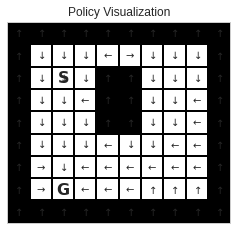

In [22]:
# @title Visualize the policy on `simple` { form-width: "30%" }

# Do here whatever works for you, but you should be able to see what the agent
# would do at each step/state.

pi = np.zeros(grid._layout_dims, dtype=np.int32)
for i in range(grid._layout_dims[0]):
  for j in range(grid._layout_dims[1]):
    pi[i, j] = greedy(q[i, j])
    
grid.plot_policy(pi)

**Task 3**: Now try on the harder `obstacle` task and visualise the resulting value functions and the greedy policy on top of these values at the end of training.

**Q:** What do you observe? 
- How does this policy compare with the optimal one?
- Try running the training process longer -- what do you observe?

AFTER 100000.0 STEPS ...


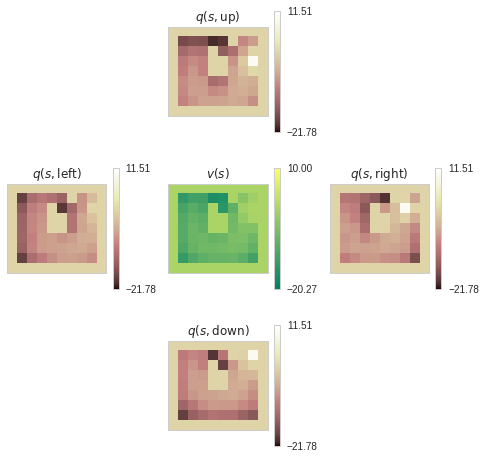

In [23]:
num_steps = 1e5 #@param {type:"number"}

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# agent 
agent = PolicyEvalAgent(
    number_of_states=environment_spec.observations.num_values, 
    number_of_actions=environment_spec.actions.num_values, 
    evaluated_policy=random_policy,
    behaviour_policy=random_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=1.)

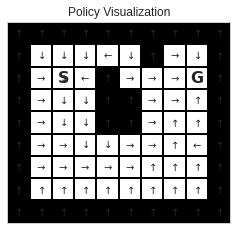

In [24]:
# @title Visualise the greedy policy on `obstacle` { form-width: "30%" }
grid.plot_greedy_policy(q)

## 1.2 On-policy control: SARSA Agent
In this section, we are focusing on control RL algorithms, which perform the evaluation and improvement of the policy synchronously. That is, the policy that is being evaluated improves as the agent is using it to interact with the environent.


The first algorithm we are going to be looking at is SARSA. This is an **on-policy algorithm** -- i.e: the data collection is done by leveraging the policy we're trying to optimize (and not just another fixed behaviour policy). 

As discussed during lectures, a greedy policy with respect to a given estimate of $Q^\pi$ fails to explore the environment as needed; we will use instead an $\epsilon$-greedy policy WRT $Q^\pi$.

### SARSA Algorithm


**Initialize** $Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}(\color{red}s)$

**Loop forever**:

1. $\color{red}s \gets{}$current (nonterminal) state
 
1. $\color{blue}a \gets{} \text{epsilon_greedy}(Q(\color{red}s, \cdot))$
 
1. Take action $\color{blue}a$; observe resultant reward $\color{green}r$, discount $\gamma$, and state, $\color{red}{s'}$

1. $\color{blue}{a'} \gets{} \text{epsilon_greedy}(Q(\color{red}{s'}, \cdot))$
 
1. $Q(\color{red}s, \color{blue}a) \gets Q(\color{red}s, \color{blue}a) + \alpha (\color{green}r + \gamma Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}s, \color{blue}a))$

In [25]:
# @title **[Coding Task]** Epilson-greedy policy { form-width: "30%" }
# Input(s): Q(s,:), epsilon
# Output:   Sampled action based on epsilon-Greedy(Q(s,:))
def epsilon_greedy(q_values, epsilon=0.1):
  pass
  #return the epsilon greedy action

In [26]:
# @title **[Solution]** Epilson-greedy policy { form-width: "30%" }
def epsilon_greedy(q_values, epsilon=0.1):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

In [27]:
#@title **[Coding Task]** SARSA Agent  { form-width: "30%" }
class SarsaAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, epsilon, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._step_size = step_size
    self._epsilon = epsilon
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # ============ YOUR CODE HERE =============
    # Online Q-value update
    # self._td_error =
    pass

  def update(self):
    # ============ YOUR CODE HERE =============
    # Q-value table update
    pass

In [28]:
#@title **[Solution]** SARSA Agent { form-width: "30%" }
class SarsaAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, epsilon, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._number_of_states = number_of_states
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._epsilon = epsilon
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    next_a = epsilon_greedy(self._q[next_s], self._epsilon)
    
    # Online Q-value update
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    s = self._state
    a = self._action
    self._q[s, a] += self._step_size * self._td_error
    self._state = self._next_state

### **Task**: Run your SARSA agent on the `obstacle` environment

AFTER 100000.0 STEPS ...


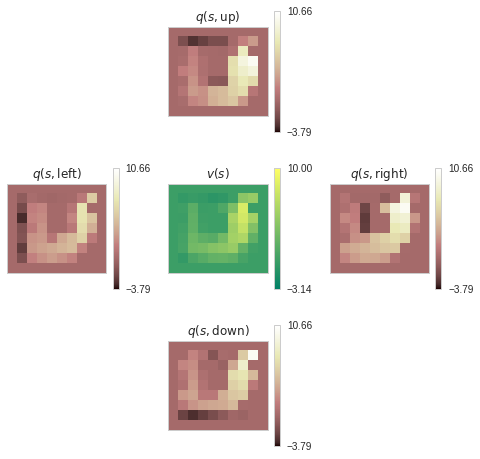

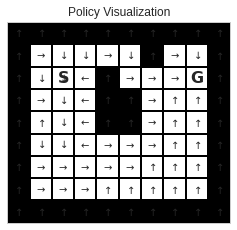

In [29]:
num_steps = 1e5 #@param {type:"number"}

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# agent 
agent = SarsaAgent(
    number_of_states=environment_spec.observations.num_values, 
    number_of_actions=environment_spec.actions.num_values, 
    epsilon=0.1,
    step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=1.)

# visualise the greedy policy
grid.plot_greedy_policy(q)

## 1.3 Off-policy control: Q-learning Agent

Reminder: Q-learning is a very powerful and general algorithm, that enables control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s} \in \color{red}{\mathcal{S}}$ and $\color{blue}{a} \in \color{blue}{\mathcal{A}}(\color{red}{s})$

**Loop forever**:

1. $\color{red}{s} \gets{}$current (nonterminal) state
 
2. $\color{blue}{a} \gets{} \text{behaviour_policy}(\color{red}{s})$
 
3. Take action $\color{blue}{a}$; observe resultant reward $\color{green}{R}$, discount $\gamma$, and state, $\color{red}{s'}$

4. $Q(\color{red}{s}, \color{blue}{a}) \gets Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{R} + \gamma \max_{\color{blue}{a'}} Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}{s}, \color{blue}{a}))$

In [30]:
#@title **[Coding Task]** Q-Learning Agent  { form-width: "30%" }
class QLearningAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, behaviour_policy, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # ============ YOUR CODE HERE =============
    # Offline Q-value update
    # self._td_error =
    pass

  def update(self):
    # ============ YOUR CODE HERE =============
    pass

In [31]:
#@title **[Solution]** Q-Learning Agent { form-width: "30%" }
class QLearningAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, behaviour_policy, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._state = None
    self._action = None
    self._next_state = None
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # Offline Q-value update
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

  def update(self):
    s = self._state
    a = self._action
    self._q[s, a] += self._step_size * self._td_error
    self._state = self._next_state

### **Task 1**: Run your Q-learning agent on `obstacle`



AFTER 100000.0 STEPS ...


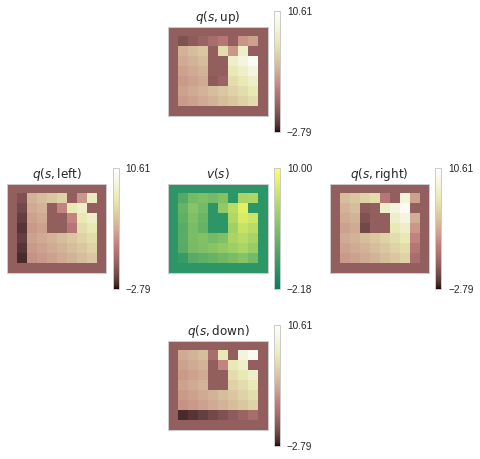

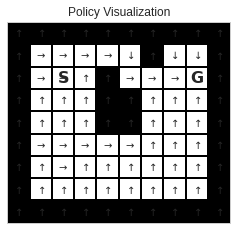

In [32]:
epsilon =   1.0#@param {type:"number"} 
num_steps = 1e5  #@param {type:"number"}

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(
    number_of_states=environment_spec.observations.num_values,
    number_of_actions=environment_spec.actions.num_values,
    behaviour_policy=behavior_policy,
    step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4,))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)

# visualise the greedy policy
grid.plot_greedy_policy(q)

### **Task 2:** Experiment with different levels of 'greediness'
* The default was $\epsilon=1.$, what does this correspond to?
* Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

## 1.4 Recap: Policy iteration vs. SARSA vs. Q-learning

The table below captures the main differences between the three algorithms we just discussed.

<table width="700">
  <colgroup>
      <col span="1" width="100">
      <col span="1" width="190">
      <col span="1" width="150">
      <col span="1" width="400">
  </colgroup>
  <tbody>
    <tr>
      <td height="20"> <b> Algorithm </b> </td>
      <td> <b> Behaviour policy </b> </td>
      <td> <b> Evaluated policy </b> </td>
      <td> <b> Update rule </b> </td>
    </tr>
    <tr>
      <td height="50"> Policy Iteration </td>
      <td> any (e.g. random) --> off-policy </td>
      <td> changes periodically </td>
      <td> $Q(\color{red}s, \color{blue}a) \gets Q(\color{red}s, \color{blue}a) + \alpha (\color{green}R + \gamma Q(\color{red}{s'}, \underbrace{\pi_e(\color{red}{s'}}_{\color{blue}{a'}})) − Q(\color{red}s, \color{blue}a))$  </td>
    </tr>
    <tr>
      <td height="50"> SARSA </td>
      <td> epsilon-greedy --> on-policy </td>
      <td> changes after every step </td>
      <td> $Q(\color{red}s, \color{blue}a) \gets Q(\color{red}s, \color{blue}a) + \alpha (\color{green}R + \gamma Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}s, \color{blue}a))$   </td>
    </tr>
    <tr>
      <td height="50"> Q-learning </td>
      <td> any (e.g. random) --> off-policy </td>
      <td> changes after every step </td>
      <td> $Q(\color{red}{s}, \color{blue}{a}) \gets Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{R} + \gamma \max_{\color{blue}{a'}} Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}{s}, \color{blue}{a}))$   </td>
    </tr>
  </tbody>
</table>

$ $     

## 1.5 **[Homework]** Experience Replay

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled from the *replay buffer* (in addition to the online updates).


**Initialize** $Q(\color{red}s, \color{blue}a)$ for all $\color{red}{s} ∈ \mathcal{\color{red}S}$ and $\color{blue}a ∈ \mathcal{\color{blue}A}(\color{red}s)$

**Loop forever**:

1. $\color{red}{s} \gets{}$current (nonterminal) state
 
2. $\color{blue}{a} \gets{} \text{random_action}(\color{red}{s})$
 
3. Take action $\color{blue}{a}$; observe resultant reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

4. $Q(\color{red}{s}, \color{blue}{a}) \gets Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{r} + \gamma Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}{s}, \color{blue}{a}))$

5. $\text{ReplayBuffer.append_transition}(s, a, r, \gamma, s')$

6. Loop repeat n times:

  1. $\color{red}{s}, \color{blue}{a}, \color{green}{r}, \gamma, \color{red}{s'} \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(\color{red}{s}, \color{blue}{a}) \gets Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{r} + \gamma \max_\color{blue}{a'} Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}{s}, \color{blue}{a}))$

In [33]:
#@title **[Coding Task]** Q-learning AGENT with a simple replay buffer { form-width: "30%" }
class ReplayQLearningAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, behaviour_policy, 
      num_offline_updates=0, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._num_offline_updates = num_offline_updates
    self._state = None
    self._action = None
    self._next_state = None
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # Offline Q-value update
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

    if self._num_offline_updates > 0:
      # ============ YOUR CODE HERE =============
      # Update replay buffer.
      pass
    
  def update(self):
    s = self._state
    a = self._action
    self._q[s, a] += self._step_size * self._td_error
    self._state = self._next_state

    # Offline Q-value update
    # ============ YOUR CODE HERE =============

In [34]:
#@title **[Solution]**  Q-learning AGENT with a simple replay buffer { form-width: "30%" }
class ReplayQLearningAgent(acme.Actor):

  def __init__(
      self, number_of_states, number_of_actions, behaviour_policy, 
      num_offline_updates=0, step_size=0.1): 
    self._q = np.zeros((number_of_states, number_of_actions))
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._num_offline_updates = num_offline_updates
    self._state = None
    self._action = None
    self._next_state = None
    self._replay_buffer = []
    
  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])
    
  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    
    # Offline Q-value update
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

    if self._num_offline_updates > 0:
      self._replay_buffer.append((s, a, r, g, next_s))

  def update(self):
    s = self._state
    a = self._action
    self._q[s, a] += self._step_size * self._td_error
    self._state = self._next_state

    # Offline Q-value update
    if len(self._replay_buffer) > self._num_offline_updates:
      for i in range(self._num_offline_updates):
        idx = np.random.randint(0, len(self._replay_buffer))
        s, a, r, g, next_s = self._replay_buffer[idx]
        td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]
        self._q[s, a] += self._step_size * td_error

### **Task**: Compare Q-learning with/without experience replay

Use a small number of training steps (e.g. `num_steps = 1e3`) and vary `num_offline_updates` between `0` and `30`.

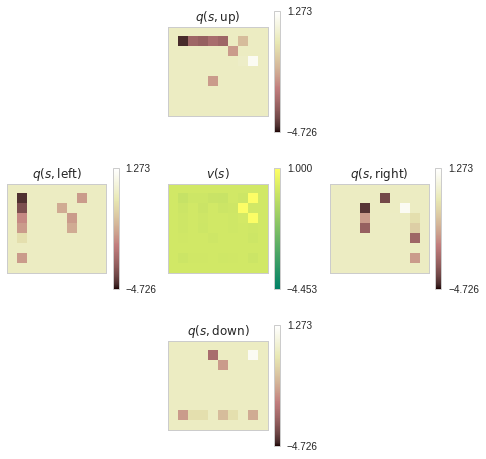

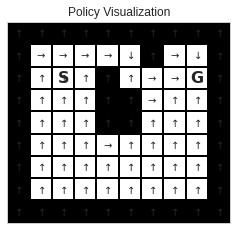

In [35]:
num_offline_updates = 0#@param {type:"integer"}
num_steps = 1e3

grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

agent = ReplayQLearningAgent(
    number_of_states=environment_spec.observations.num_values,
    number_of_actions=environment_spec.actions.num_values,
    behaviour_policy=random_policy,
    num_offline_updates=num_offline_updates,
    step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

grid.plot_greedy_policy(q)

# RL Lab - Part 2: Function Approximation

<img src="https://drive.google.com/uc?id=1oqIQNM_tMPmP8l38C_3yp5uUego3S8kV" width="500" />

So far we only considered look-up tables. In all previous cases every state and action pair $(\color{red}{s}, \color{blue}{a})$, had an entry in our Q table. Again, this is possible in this environment as the number of states is a equal to the number of cells in the grid. But this is not scalable to situations where, say, the goal location changes or the obstacles are in different locations at every episode (consider how big the table should be in this situation?).

As example (not covered in this tutorial) is ATARI from pixels, where the number of possible frames an agent can see is exponential in the number of pixels on the screen.

<center><img width="200" alt="portfolio_view" src="https://miro.medium.com/max/1760/1*XyIpmXXAjbXerDzmGQL1yA.gif"></center>

But what we **really** want is just being able to *compute* the Q-value, when fed with a particular $(\color{red}{s}, \color{blue}{a})$ pair. So if we had a way to get a function to do this work instead of keeping a big table, we'd get around this problem.

To address this, we can use **Function Approximation** as a way to generalize Q-values over some representation of the very large state space, and **train** them to output the values they should. In this section, we will explore Q-Learning with function approximation, which, although theoretically proven to diverge for some degenerate MDPs, can yield impressive results in very large environments. In particular, we will look at [Neural Fitted Q (NFQ) Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf).




## 2.1 NFQ agent

[Neural Fitted Q Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) was one of the first papers to demonstrate how to leverage recent advances in Deep Learning to approximate the Q-value by a neural network $^1$.

We represent $Q(\color{red}s, \color{blue}a)$ as a neural network $f()$. which given a vector $\color{red}s$, will output a vector of Q-values for all possible actions $\color{blue}a$.$^2$

When introducing function approximations, and neural networks in particular, we need to have a loss to optimize. But looking back at the tabular setting above, you can see that we already have some notion of error: the **TD error**.

By training our neural network to output values such that the *TD error is minimized*, we will also satisfy the Bellman Optimality Equation, which is a good sufficient condition to enforce, so that we may obtain an optimal policy.
Thanks to automatic differentiation, we can just write the TD error as a loss (e.g. with a $L2$ loss, but others would work too), compute its gradient (which are now gradients with respect to individual parameters of the neural network) and slowly improve our Q-value approximation:

$$Loss = \mathbb{E}\left[ \left( \color{green}{r} + \gamma \max_\color{blue}{a'} Q(\color{red}{s'}, \color{blue}{a'}) − Q(\color{red}{s}, \color{blue}{a})  \right)^2\right]$$


NFQ builds on Q-learning, but if one were to update the Q-values online directly, the training can be unstable and very slow.
Instead, NFQ uses a Replay buffer, similar to what you just implemented above, to update the Q-value in a batched setting.

When it was introduced, it also was entirely off-policy (i.e. one would use a random policy to collect data), and is prone to unstability when applied to more complex environments (e.g. when the input are pixels or the tasks are longer and complicated).
But it is a good stepping stone to the more complex agents used today. Here, we will look at a slightly different and modernised implementation of NFQ.

<br />

---

<sub>*$^1$ if you read the NFQ paper, they use a "control" notation, where there is a "cost to minimize", instead of "rewards to maximize", so don't be surprised if signs/max/min do not correspond.* </sub>

<sub>*$^2$ we could feed it $\color{blue}a$ as well and ask $f$ for a single scalar value, but given we have a fixed number of actions and we usually need to take an $argmax$ over them, it's easiest to just output them all in one pass.*</sub>

<center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="400" /></center> 

In [36]:
#@title **[Coding Task]** NFQ Agent  { form-width: "30%" }

Transitions = collections.namedtuple('Transitions',
                                     ['s_t', 'a_t', 'r_t', 'd_t', 's_tp1'])
TrainingState = namedtuple('TrainingState', 'params, opt_state, step')


class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               q_network,
               observation_spec,
               replay_capacity=100000,
               epsilon=0.1,
               batch_size=1,
               learning_rate=3e-4):

    self._observation_spec = observation_spec
    self.epsilon = epsilon
    self._batch_size = batch_size
    self._replay_buffer = ReplayBuffer(replay_capacity)
    self.last_loss = 0

    # Setup Network and loss with Haiku
    self._rng = hk.PRNGSequence(1)
    self._q_network = hk.transform(q_network)

    # Initialize network
    # ============ YOUR CODE HERE =============
    # init_params = 

    # Setup optimizer
    self._optimizer = optix.adam(learning_rate)
    initial_optimizer_state = self._optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params, opt_state=initial_optimizer_state, step=0)

  @functools.partial(jax.jit, static_argnums=(0,))
  def _policy(self, params: hk.Params, rng_key: jnp.ndarray,
              observation: jnp.ndarray, epsilon: float):
    # You can use rlax.epsilon_greedy here
    # ============ YOUR CODE HERE =============
    pass

  def select_action(self, observation):
    return self._policy(self._state.params, next(self._rng), observation,
                        self.epsilon)

  def q_values(self, observation):
    return jnp.squeeze(
        self._q_network.apply(self._state.params, observation[None, ...]),
        axis=0)

  @functools.partial(jax.jit, static_argnums=(0,))
  def _loss(self, params: hk.Params, transitions: Transitions):

    def _td_error(q_s, q_next_s, a, r, d):
      """TD error for a single transition."""
      # ============ YOUR CODE HERE =============
      pass

    batch_td_error = jax.vmap(_td_error)

    # Compute batched Q-values [Batch, actions]
    q_s = self._q_network.apply(params, transitions.s_t)
    q_next_s = self._q_network.apply(params, transitions.s_tp1)
    # Get batched td errors
    td_errors = batch_td_error(q_s, q_next_s, transitions.a_t, transitions.r_t,
                               transitions.d_t)
    losses = 0.5 * td_errors**2.  # [Batch]

    return jnp.mean(losses)

  @functools.partial(jax.jit, static_argnums=(0,))
  def _train_step(self, state: TrainingState, transitions: Transitions):
    # Do one learning step on the batch of transitions
    # ============ YOUR CODE HERE =============
    # Use jax.value_and_grad to compute gradients and values from _loss, 
    # and optix.apply_updates to compute new parameters for the network.
   
    new_state = TrainingState(
        params=new_params, opt_state=new_opt_state, step=state.step + 1)
    return new_state, loss

  def update(self):
    if self._replay_buffer.is_ready(self._batch_size):
      # Collect a minibatch of random transitions
      transitions = Transitions(*self._replay_buffer.sample(self._batch_size))
      # Compute loss and update parameters
      self._state, self.last_loss = self._train_step(self._state, transitions)

  def observe_first(self, timestep):
    self._replay_buffer.push(timestep, None)

  def observe(self, action, next_timestep):
    self._replay_buffer.push(next_timestep, action)


class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity):
    self._prev = None
    self._action = None
    self._latest = None
    self.buffer = collections.deque(maxlen=capacity)

  def push(self, timestep, action):
    self._prev = self._latest
    self._action = action
    self._latest = timestep

    if action is not None:
      self.buffer.append(
          (self._prev.observation, self._action, self._latest.reward,
           self._latest.discount, self._latest.observation))

  def sample(self, batch_size):
    obs_tm1, a_tm1, r_t, discount_t, obs_t = zip(
        *random.sample(self.buffer, batch_size))
    return (jnp.stack(obs_tm1), jnp.asarray(a_tm1), jnp.asarray(r_t),
            jnp.asarray(discount_t), jnp.stack(obs_t))

  def is_ready(self, batch_size):
    return batch_size <= len(self.buffer)

In [37]:
#@title **[Solution]** NFQ Agent  { form-width: "30%" }

Transitions = collections.namedtuple('Transitions',
                                     ['s_t', 'a_t', 'r_t', 'd_t', 's_tp1'])
TrainingState = namedtuple('TrainingState', 'params, opt_state, step')


class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               q_network,
               observation_spec,
               replay_capacity=100000,
               epsilon=0.1,
               batch_size=1,
               learning_rate=3e-4):

    self._observation_spec = observation_spec
    self.epsilon = epsilon
    self._batch_size = batch_size
    self._replay_buffer = ReplayBuffer(replay_capacity)
    self.last_loss = 0

    # Setup Network and loss with Haiku
    self._rng = hk.PRNGSequence(1)
    self._q_network = hk.without_apply_rng(hk.transform(q_network))
    
    # Initialize network
    dummy_observation = observation_spec.generate_value()
    initial_params = self._q_network.init(
        next(self._rng), dummy_observation[None, ...])

    # Setup optimizer
    self._optimizer = optax.adam(learning_rate)
    initial_optimizer_state = self._optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params, opt_state=initial_optimizer_state, step=0)

  @functools.partial(jax.jit, static_argnums=(0,))
  def _policy(self, params: hk.Params, rng_key: jnp.ndarray,
              observation: jnp.ndarray, epsilon: float):
    q_values = self._q_network.apply(params, observation[None, ...])
    actions = rlax.epsilon_greedy(epsilon).sample(rng_key, q_values)
    return jnp.squeeze(actions, axis=0)

  def select_action(self, observation):
    return self._policy(self._state.params, next(self._rng), observation,
                        self.epsilon)

  def q_values(self, observation):
    return jnp.squeeze(
        self._q_network.apply(self._state.params, observation[None, ...]),
        axis=0)

  @functools.partial(jax.jit, static_argnums=(0,))
  def _loss(self, params: hk.Params, transitions: Transitions):

    def _td_error(q_s, q_next_s, a, r, d):
      """TD error for a single transition."""
      target_s = r + d * jnp.max(q_next_s)
      td_error = jax.lax.stop_gradient(target_s) - q_s[a]
      # Task: think of why we are not using td_error = target_s - q_s[a]? 
      return td_error

    batch_td_error = jax.vmap(_td_error)

    # Compute batched Q-values [Batch, actions]
    q_s = self._q_network.apply(params, transitions.s_t)
    q_next_s = self._q_network.apply(params, transitions.s_tp1)
    # Get batched td errors
    td_errors = batch_td_error(q_s, q_next_s, transitions.a_t, transitions.r_t,
                               transitions.d_t)
    losses = 0.5 * td_errors**2.  # [Batch]

    return jnp.mean(losses)

  @functools.partial(jax.jit, static_argnums=(0,))
  def _train_step(self, state: TrainingState, transitions: Transitions):
    # Do one learning step on the batch of transitions
    compute_loss_and_grad = jax.value_and_grad(self._loss)
    loss, dloss_dparams = compute_loss_and_grad(state.params, transitions)
    updates, new_opt_state = self._optimizer.update(dloss_dparams,
                                                    state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params, opt_state=new_opt_state, step=state.step + 1)
    return new_state, loss

  def update(self):
    if self._replay_buffer.is_ready(self._batch_size):
      # Collect a minibatch of random transitions
      transitions = Transitions(*self._replay_buffer.sample(self._batch_size))
      # Compute loss and update parameters
      self._state, self.last_loss = self._train_step(self._state, transitions)

  def observe_first(self, timestep):
    self._replay_buffer.push(timestep, None)

  def observe(self, action, next_timestep):
    self._replay_buffer.push(next_timestep, action)


class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity):
    self._prev = None
    self._action = None
    self._latest = None
    self.buffer = collections.deque(maxlen=capacity)

  def push(self, timestep, action):
    self._prev = self._latest
    self._action = action
    self._latest = timestep

    if action is not None:
      self.buffer.append(
          (self._prev.observation, self._action, self._latest.reward,
           self._latest.discount, self._latest.observation))

  def sample(self, batch_size):
    obs_tm1, a_tm1, r_t, discount_t, obs_t = zip(
        *random.sample(self.buffer, batch_size))
    return (jnp.stack(obs_tm1), jnp.asarray(a_tm1), jnp.asarray(r_t),
            jnp.asarray(discount_t), jnp.stack(obs_t))

  def is_ready(self, batch_size):
    return batch_size <= len(self.buffer)

### **Task: Train a NFQ agent**



In [38]:
#@title Training the NFQ Agent.  { form-width: "30%" }
epsilon = 1. #@param {type:"number"}
num_episodes = 300 #@param {type:"number"}

max_episode_length = 200

# Environment
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.AGENT_GOAL_POS,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Define function approximation for the Q-values
# i.e. Q_a(s) for a in num_actions.
def q_network(observation: np.ndarray):
  """Outputs action values given an observation."""
  model = hk.Sequential([
      hk.Flatten(),  # Flattens everything except the batch dimension
      hk.nets.MLP([50, 50, environment_spec.actions.num_values])
  ])
  return model(observation)

# Build the trainable Q-learning agent
agent = NeuralFittedQAgent(
    q_network,
    environment_spec.observations,
    epsilon=epsilon,
    replay_capacity=100000,
    batch_size=10,
    learning_rate=1e-3)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=num_episodes,
    logger_time_delta=1.,
    log_loss=True)

### Evaluate the policy it learned

In [39]:
#@title Evaluating the agent.  { form-width: "30%" }

# Change epsilon to be more greedy
agent.epsilon = 0.05

# Look at a few episodes
frames = evaluate(environment, agent, evaluation_episodes=5)
display_video(frames, frame_repeat=10)

Episode 0 ended with reward 10.0 in 5 steps
Episode 1 ended with reward 10.0 in 7 steps
Episode 2 ended with reward 10.0 in 5 steps
Episode 3 ended with reward 10.0 in 5 steps
Episode 4 ended with reward 10.0 in 5 steps


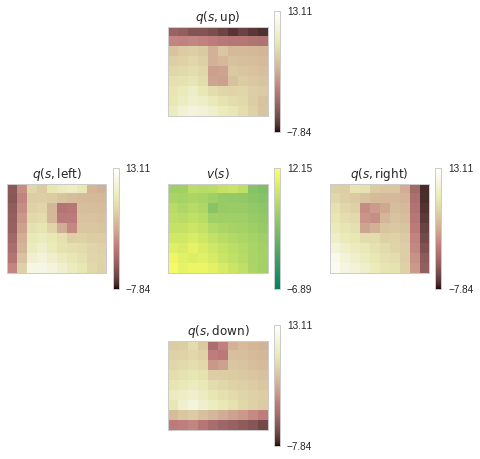

In [40]:
#@title Visualise the learned Q values

# Evaluate the policy for every state, similar to tabular agents above.

environment.reset()
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))
    
plot_action_values(q)

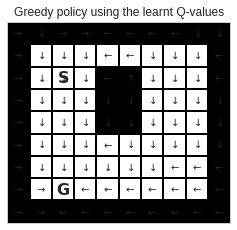

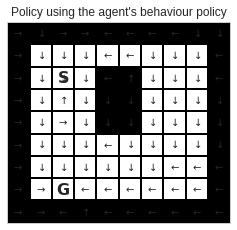

In [41]:
#@title Compare the greedy policy with the behaviour policy { form-width: "30%" }

grid.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

grid.plot_policy(pi)
_ = plt.title("Policy using the agent's behaviour policy")

# RL Lab - Part 3: Deep Reinforcement Learning


<!-- <center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="500" /></center>  -->

<center><img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature14236/MediaObjects/41586_2015_Article_BFnature14236_Fig1_HTML.jpg" width="500" /></center> 

In this subsection, we will look at an advanced deep RL Agent based on the following publication, [Playing Atari with Deep Reinforcement Learning](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning), which introduced the first deep learning model to successfully learn control policies directly from high-dimensional pixel inputs using RL.


 ## 3.1 Create an ACME DQN agent

In [42]:
#@title Create the environment
grid = build_gridworld_task(
    task='simple', 
    observation_type=ObservationType.GRID,
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

In [43]:
#@title Construct the agent and a training loop  { form-width: "30%" }

# Build agent network module
def _network(x):
  model = hk.Sequential([
      hk.Conv2D(32, kernel_shape=[4,4], stride=[2,2], padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(64, kernel_shape=[3,3], stride=[1,1], padding='VALID'),
      jax.nn.relu,
      hk.Flatten(),
      hk.nets.MLP([50, 50, environment_spec.actions.num_values])
  ])
  return model(x)

# Create agent network pure functions and prebind the observation shape.
hk_network: hk.Transformed = hk.without_apply_rng(hk.transform(_network))
observation_spec = environment_spec.observations
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)

# Pack the network pure functions.
# Here we also prebind a dummy observation to the network initialization
# function. This is so that Acme can maintain compatibility with both haiku and
# flax.
network = acme.jax.networks.FeedForwardNetwork(
    init=lambda rng_key: hk_network.init(rng_key, dummy_observation),
    apply=hk_network.apply,
)

# Avoid logging from Acme
class DummyLogger(object):

  def write(self, data):
    pass

# Use library agent implementation.
agent = dqn.DQN(
    environment_spec=environment_spec,
    network=network,
    batch_size=10,
    samples_per_insert=2,
    epsilon=0.05,
    min_replay_size=10,)

In [44]:
# @title Run a training loop  { form-width: "30%" }
num_episodes = 100  # @param {type: "number"}

# Run a `num_episodes` training episodes.
# Rerun this cell until the agent has learned the given task.
returns = run_loop(environment=environment, agent=agent, num_episodes=100, num_steps=100000, logger_time_delta=0.2 )

In [52]:
# @title Visualise the learned Q values { form-width: "30%" }

# get agent parameters
params = agent._learner.get_variables([])[0]

# Evaluate the policy for every state, similar to tabular agents above.
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent._learner.network.apply(params, np.expand_dims(obs, axis=0)))
    pi[y, x] = np.asarray(agent.select_action(obs))
    
plot_action_values(q)

TypeError: ignored

Text(0.5, 1.0, "Policy using the agent's policy")

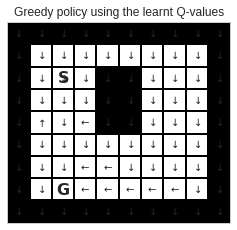

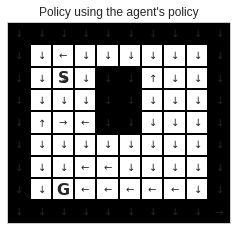

In [46]:
#@title Compare the greedy policy with the agent's policy { form-width: "30%" }

grid.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

grid.plot_policy(pi)
plt.title("Policy using the agent's policy")

## 3.2 **[Advanced]** DQN Algorithm.

The following coding exercise implements the loss function described in the DQN paper. This loss function is used by a learner class to compute gradients for the parameters $\theta_i$ of the Q-network $Q( \cdot; \theta_i)$:

```none
loss(params: hk.Params, target_params: hk.Params, sample: reverb.ReplaySample)
```
which, at iteration `i` computes the DQN loss $L_i$ on the parameters $\theta_i$, based on a the set of target parameters $\theta_{i-1}$ and a given batch of sampled trajectories `sample`. As described in the manuscript, the loss function is defined as:

$$L_i (\theta_i) = \mathbb{E}_{\color{red}{s},\color{blue}{a} \sim \rho(\cdot)} \left[ \left( y_i - Q(\color{red}{s},\color{blue}{a} ;\theta_i) \right)^2\right]$$

where the target $y_i$ is computed using a bootstrap value computed from Q-value network with target parameters:

$$ y_i = \mathbb{E}_{\color{red}{s'} \sim \mathcal{E}} \left[ \color{green}{r} + \gamma \max_{\color{blue}{a'} \in \color{blue}{\mathcal{A}}} Q(\color{red}{s'}, \color{blue}{a'} ; \theta^{\text{target}}_i) \; | \; \color{red}{s}, \color{blue}{a} \right] $$

The batch of data `sample` is prepackaged by the agent to match the sampling distributions $\rho$ and $\mathcal{E}$. To get the explicit data items, use the following:

```none
o_tm1, a_tm1, r_t, d_t, o_t = sample.data
```

The function is expected to return  
* `mean_loss` is the mean of the above loss over the batched data,
* (`keys`, `priorities`) will pair the `keys` corresponding to each batch item to the absolute TD-error used to compute the `mean_loss` above. The agent uses these to update priorities for samples in the replay buffer.


**Note**. A full implementation of a DQN agent is outside the scope of this tutorial, but we encoruage you to explore the code (in a cell below) to understand where the learner fits with other the services used by the agent. Moreover, if you feel ambitious, we prepared a separate exercise where you are expected to implement the learner itself (see  *DQN Learner [Coding Task - Hard]*).



**[Optional]**
- use a Double-Q Learning Loss function instead of the original published loss (see [`rlax.double_q_learning`](https://github.com/deepmind/rlax/blob/870cba1ea8ad36725f4f3a790846298657b6fd4b/rlax/_src/value_learning.py#L233)) for more details.
- for more stable optimization, use the Huber Loss instead of $L_2$, as prescribed in the manuscript (see [`rlax.huber_loss`](https://github.com/deepmind/rlax/blob/870cba1ea8ad36725f4f3a790846298657b6fd4b/rlax/_src/clipping.py#L31)).


In [47]:
# @title **[Coding Task - Easy]** DQN Loss function  { form-width: "30%" }

TrainingState =  namedtuple('TrainingState', 'params, target_params, opt_state, step')
LearnerOutputs =  namedtuple('LearnerOutputs', 'keys, priorities')

class DQNLearner(acme.Learner):
  """DQN learner."""

  _state: TrainingState

  def __init__(self,
               network,
               obs_spec,
               discount,
               importance_sampling_exponent,
               target_update_period,
               data_iterator,
               optimizer,
               rng,
               replay_client,
               max_abs_reward=1.,
               huber_loss_parameter=1.,
               ):
    """Initializes the learner."""

    # Transform network into a pure function.
    network = hk.transform(network)

    def loss(params: hk.Params, target_params: hk.Params,
             sample: reverb.ReplaySample):
      o_tm1, a_tm1, r_t, d_t, o_t, _ = sample.data
      keys, probs = sample.info[:2]
      
      # ============ YOUR CODE HERE =============
      # return mean_loss, (keys, priorities)

      pass
      

    def sgd_step(state, samples):
      # Compute gradients on the given loss function and update the network
      # using the optimizer provided at init time.
      grad_fn = jax.grad(loss, has_aux=True)
      gradients, (keys, priorities) = grad_fn(state.params, state.target_params,
                                              samples)
      updates, new_opt_state = optimizer.update(gradients, state.opt_state)
      new_params = optax.apply_updates(state.params, updates)

      # Update the internal state for the learner with (1) network parameters,
      # (2) parameters of the target network, (3) the state of the optimizer,
      # (4) Numbers of SGD steps performed by the agent.  
      new_state = TrainingState(
          params=new_params,
          target_params=state.target_params,
          opt_state=new_opt_state,
          step=state.step + 1)

      outputs = LearnerOutputs(keys=keys, priorities=priorities)
      return new_state, outputs

    # Internalise agent components (replay buffer, networks, optimizer).
    self._replay_client = replay_client
    self._iterator = data_iterator

    # Since sampling is base on a priority experience replay, we need to pass
    # the absolute td-loss values to the replay client to update priorities
    # accordingly.
    def update_priorities(outputs: LearnerOutputs):
      for key, priority in zip(outputs.keys, outputs.priorities):
        self._replay_client.mutate_priorities(
            table='priority_table', 
            updates={key: priority})
        
    self._update_priorities = update_priorities

    # Internalise the hyperparameters.
    self._target_update_period = target_update_period

    # Internalise logging/counting objects.
    self._counter = counting.Counter()
    self._logger = loggers.TerminalLogger('learner', time_delta=1.)

    # Initialise parameters and optimiser state.
    def initialization_fn(values):
      values = tree_util.tree_map(lambda x: jnp.zeros(x.shape, x.dtype), values)
      # Add batch dim.
      return tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), values)

    initial_params = network.init(next(rng))
    initial_target_params = initial_params
    initial_opt_state = optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params,
        target_params=initial_target_params,
        opt_state=initial_opt_state,
        step=0)

    self._forward = jax.jit(network.apply)
    self._sgd_step = jax.jit(sgd_step)
    
  def step(self):
    samples = next(self._iterator)
    # Do a batch of SGD.
    self._state, outputs = self._sgd_step(self._state, samples)

    # Update our counts and record it.
    result = self._counter.increment(steps=1)

    # Periodically update target network parameters.
    if self._state.step % self._target_update_period == 0:
      self._state = self._state._replace(target_params=self._state.params)

    # Update priorities in replay.
    self._update_priorities(outputs)

    # Write to logs.
    self._logger.write(result)

  def get_variables(self):
    """Network variables after a number of SGD steps."""
    return self._state.params

In [48]:
# @title **[Coding Task - Hard]** DQN Learner  { form-width: "30%" }

TrainingState =  namedtuple('TrainingState', 'params, target_params, opt_state, step')
LearnerOutputs =  namedtuple('LearnerOutputs', 'keys, priorities')

class DQNLearner(acme.Learner):
  """DQN learner."""

  _state: TrainingState

  def __init__(self,
               network,
               obs_spec,
               discount,
               importance_sampling_exponent,
               target_update_period,
               data_iterator,
               optimizer,
               rng,
               replay_client,
               max_abs_reward=1.,
               huber_loss_parameter=1.,
               ):
    """Initializes the learner."""

    # ============ YOUR CODE HERE =============
    # Use provided params to initialize any jax functions used in the `step`
    # function.
    
    # Internalise agent components (replay buffer, networks, optimizer).
    self._replay_client = replay_client
    self._iterator = data_iterator

    # Since sampling is base on a priority experience replay, we need to pass
    # the absolute td-loss values to the replay client to update priorities
    # accordingly.
    def update_priorities(outputs: LearnerOutputs):
      for key, priority in zip(outputs.keys, outputs.priorities):
        self._replay_client.mutate_priorities(
            table='priority_table', 
            updates={key: priority})
        
    self._update_priorities = update_priorities

    # Internalise the hyperparameters.
    self._target_update_period = target_update_period

    # Internalise logging/counting objects.
    self._counter = counting.Counter()
    self._logger = loggers.TerminalLogger('learner', time_delta=1.)

    # Initialise parameters and optimiser state.

    # Transform network into a pure function.
    network = hk.transform(network)

    def initialization_fn(values):
      values = tree_util.tree_map(lambda x: jnp.zeros(x.shape, x.dtype), values)
      # Add batch dim.
      return tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), values)

    initial_params = network.init(next(rng))
    initial_target_params = initial_params
    initial_opt_state = optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params,
        target_params=initial_target_params,
        opt_state=initial_opt_state,
        step=0)

  def step(self):
    samples = next(self._iterator)
    
    # Do a batch of SGD and update self._state accordingly.
    # ============ YOUR CODE HERE =============
    
    # Update our counts and record it.
    result = self._counter.increment(steps=1)

    # Periodically update target network parameters.
    # ============ YOUR CODE HERE =============
    
    # Update priorities in replay.
    self._update_priorities(outputs)

    # Write to logs.
    self._logger.write(result)

  def get_variables(self):
    """Network variables after a number of SGD steps."""
    return self._state.params

In [49]:
# @title **[Solution]** DQN Learner  { form-width: "30%" }

TrainingState =  namedtuple('TrainingState', 'params, target_params, opt_state, step')
LearnerOutputs =  namedtuple('LearnerOutputs', 'keys, priorities')

class DQNLearner(acme.Learner):
  """DQN learner."""

  _state: TrainingState

  def __init__(self,
               network,
               obs_spec,
               discount,
               importance_sampling_exponent,
               target_update_period,
               data_iterator,
               optimizer,
               rng,
               replay_client,
               max_abs_reward=1.,
               huber_loss_parameter=1.,
               ):
    """Initializes the learner."""

    def loss(params: hk.Params, target_params: hk.Params,
             sample: reverb.ReplaySample):
      o_tm1, a_tm1, r_t, d_t, o_t, _ = sample.data  # Ignore the empty extras.
      keys, probs = sample.info[:2]

      # Forward pass.
      q_tm1 = network.apply(params, o_tm1)
      q_t_value = network.apply(target_params, o_t)
      q_t_selector = network.apply(params, o_t)

      # Cast and clip rewards.
      d_t = (d_t * discount).astype(jnp.float32)
      r_t = jnp.clip(r_t, -max_abs_reward, max_abs_reward).astype(jnp.float32)

      # Compute double Q-learning n-step TD-error.
      batch_error = jax.vmap(rlax.double_q_learning)
      td_error = batch_error(q_tm1, a_tm1, r_t, d_t, q_t_value, q_t_selector)
      batch_loss = rlax.huber_loss(td_error, huber_loss_parameter)

      # Importance weighting.
      importance_weights = (1. / probs).astype(jnp.float32)
      importance_weights **= importance_sampling_exponent
      importance_weights /= jnp.max(importance_weights)

      # Reweight.
      mean_loss = jnp.mean(importance_weights * batch_loss)  # []

      priorities = jnp.abs(td_error).astype(jnp.float64)

      return mean_loss, (keys, priorities)

    def sgd_step(state, samples):
      # Compute gradients on the given loss function and update the network
      # using the optimizer provided at init time.
      grad_fn = jax.grad(loss, has_aux=True)
      gradients, (keys, priorities) = grad_fn(state.params, state.target_params,
                                              samples)
      updates, new_opt_state = optimizer.update(gradients, state.opt_state)
      new_params = optax.apply_updates(state.params, updates)

      # Update the internal state for the learner with (1) network parameters,
      # (2) parameters of the target network, (3) the state of the optimizer,
      # (4) Numbers of SGD steps performed by the agent.  
      new_state = TrainingState(
          params=new_params,
          target_params=state.target_params,
          opt_state=new_opt_state,
          step=state.step + 1)

      outputs = LearnerOutputs(keys=keys, priorities=priorities)

      return new_state, outputs

    # Internalise agent components (replay buffer, networks, optimizer).
    self._replay_client = replay_client
    self._iterator = data_iterator

    # Since sampling is base on a priority experience replay, we need to pass
    # the absolute td-loss values to the replay client to update priorities
    # accordingly.
    def update_priorities(outputs: LearnerOutputs):
      for key, priority in zip(outputs.keys, outputs.priorities):
        self._replay_client.mutate_priorities(
            table='priority_table', 
            updates={key: priority})
        
    self._update_priorities = update_priorities

    # Internalise the hyperparameters.
    self._target_update_period = target_update_period

    # Internalise logging/counting objects.
    self._counter = counting.Counter()
    self._logger = loggers.TerminalLogger('learner', time_delta=1.)

    # Initialise parameters and optimiser state.
    def initialization_fn(values):
      values = tree_util.tree_map(lambda x: jnp.zeros(x.shape, x.dtype), values)
      # Add batch dim.
      return tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), values)

    initial_params = network.init(next(rng))
    initial_target_params = initial_params
    initial_opt_state = optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params,
        target_params=initial_target_params,
        opt_state=initial_opt_state,
        step=0)

    self._forward = jax.jit(network.apply)
    self._sgd_step = jax.jit(sgd_step)
    
  def step(self):
    samples = next(self._iterator)
    # Do a batch of SGD.
    self._state, outputs = self._sgd_step(self._state, samples)

    # Update our counts and record it.
    result = self._counter.increment(steps=1)

    # Periodically update target network parameters.
    if self._state.step % self._target_update_period == 0:
      self._state = self._state._replace(target_params=self._state.params)

    # Update priorities in replay.
    self._update_priorities(outputs)

    # Write to logs.
    self._logger.write(result)

  def get_variables(self):
    """Network variables after a number of SGD steps."""
    return self._state.params

In [50]:
# @title DQN Agent implementation (use for reference only) { form-width: "30%" }
class DQN(acme.Actor):
  def __init__(
    self,
    environment_spec,
    network,
    batch_size=256,
    prefetch_size=4,
    target_update_period=100,
    samples_per_insert=32.0,
    min_replay_size=1000,
    max_replay_size=1000000,
    importance_sampling_exponent=0.2,
    priority_exponent=0.6,
    n_step=5,
    epsilon=0.,
    learning_rate=1e-3,
    discount=0.99,
  ):
    # Create a replay server to add data to. This is initialized as a
    # table, and a Learner (defined separately) will be in charge of updating
    # sample priorities based on the corresponding learner loss. 
    replay_table = reverb.Table(
        name='priority_table',
        sampler=reverb.selectors.Prioritized(priority_exponent),
        remover=reverb.selectors.Fifo(),
        max_size=max_replay_size,
        rate_limiter=reverb.rate_limiters.MinSize(1),
        signature=adders.NStepTransitionAdder.signature(environment_spec))
    self._server = reverb.Server([replay_table], port=None)
    address = f'localhost:{self._server.port}'

    # Use ACME reverb adder as a tool to add transition data into the replay
    # buffer defined above.
    self._adder = adders.NStepTransitionAdder(
        client=reverb.Client(address),
        n_step=n_step,
        discount=discount)

    # ACME datasets provides an interface to easily sample from a replay server.
    dataset = datasets.make_reverb_dataset(
        server_address=address,
        batch_size=batch_size,
        prefetch_size=prefetch_size)
    data_iterator = dataset.as_numpy_iterator()

    # Create a learner that updates the parameters (and initializes them).
    self._learner = DQNLearner(
        network=network,
        obs_spec=environment_spec.observations,
        rng=hk.PRNGSequence(1),
        optimizer=optax.adam(learning_rate),
        discount=discount,
        importance_sampling_exponent=importance_sampling_exponent,
        target_update_period=target_update_period,
        data_iterator=data_iterator,
        replay_client=reverb.Client(address),
    )
    
    # Create a feed forward actor that obtains its variables from the DQNLearner
    # above.
    def policy(params, key, observation):
      action_values = network.apply(params, observation)
      return rlax.epsilon_greedy(epsilon).sample(key, action_values)

    self._policy = policy
    self._rng = hk.PRNGSequence(1)
 
    # We'll ignore the first min_observations when determining whether to take
    # a step and we'll do so by making sure num_observations >= 0.
    self._num_observations = -max(batch_size, min_replay_size)

    observations_per_step = float(batch_size) / samples_per_insert
    if observations_per_step >= 1.0:
      self._observations_per_update = int(observations_per_step)
      self._learning_steps_per_update = 1
    else:
      self._observations_per_update = 1
      self._learning_steps_per_update = int(1.0 / observations_per_step)

  def select_action(self, observation):
    observation = tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), 
                                     observation)
    
    key = next(self._rng)
    params = self._learner.get_variables()
    action = self._policy(params, key, observation)
    action = tree_util.tree_map(lambda x: np.array(x).squeeze(axis=0), action)
    return action 

  def observe_first(self, timestep):
    self._adder.add_first(timestep)

  def observe(self, action, next_timestep):
    self._num_observations += 1
    self._adder.add(action, next_timestep)

  def update(self):
    # Only allow updates after some minimum number of observations have been and
    # then at some period given by observations_per_update.
    if (self._num_observations >= 0 and
        self._num_observations % self._observations_per_update == 0):
      self._num_observations = 0

      # Run a number of learner steps (usually gradient steps).
      for _ in range(self._learning_steps_per_update):
        self._learner.step()

In [51]:
# @title Run a training loop  { form-width: "30%" }

# Run a `num_episodes` training episodes.
# Rerun this cell until the agent has learned the given task.

grid = build_gridworld_task(
    task='simple', 
    observation_type=ObservationType.GRID, 
    max_episode_length=100,
)
environment, environment_spec = setup_environment(grid)

agent = DQN(
    environment_spec=environment_spec,
    network=network,
    batch_size=16,
    samples_per_insert=2,
    epsilon=0.1,
    min_replay_size=100)

returns = run_loop(environment=environment, agent=agent, num_episodes=200, 
    logger_time_delta=0.2)

TypeError: ignored

### DQN agent on the Gym Cartpole environment

Here we show that you can apply what you learned to other environments such as Cartpole in [Gym](https://gym.openai.com/).


<center><img src="https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif" height="250" /></center>


In [ ]:
#@title Construct the agent and run the training loop { form-width: "30%" }

#  Try different parameters to see how learning is affected.

env = gym_wrapper.GymWrapper(gym.make('CartPole-v0'))
env = wrappers.SinglePrecisionWrapper(env)

environment, environment_spec = setup_environment(env)

# Build agent networks
def _network(x):
  model = hk.Sequential([
      hk.Flatten(),
      hk.nets.MLP([200, environment_spec.actions.num_values])
  ])
  return model(x)

# Create agent network pure functions and prebind the observation shape.
hk_network: hk.Transformed = hk.without_apply_rng(hk.transform(_network))
observation_spec = environment_spec.observations
dummy_observation = np.zeros(observation_spec.shape, observation_spec.dtype)

# Pack the network pure functions.
# Here we also prebind a dummy observation to the network initialization
# function. This is so that Acme can maintain compatibility with both haiku and
# flax.
network = acme.jax.networks.FeedForwardNetwork(
    init=lambda rng_key: hk_network.init(rng_key, dummy_observation),
    apply=hk_network.apply,
)

agent = dqn.DQN(
    environment_spec=environment_spec,
    network=network,
    batch_size=64,
    epsilon=0.1,
    learning_rate=1e-4,
    min_replay_size=100,
    samples_per_insert=32,
    )

returns = run_loop(environment=environment, agent=agent, num_episodes=1500, 
         logger_time_delta=0.2)

In [ ]:
#@title Visualise training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Total reward');

# Want to learn more?




This Colab is based on the [EEML 2020 RL practical](https://github.com/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb) by Feryal Behbahani & Gheorghe Comanici. 


Books and lecture notes
*   [Reinforcement Learning: an Introduction by Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf)
* [Algorithms for Reinforcement Learning by Csaba Szepesvari](https://sites.ualberta.ca/~szepesva/papers/RLAlgsInMDPs.pdf)


Lectures and course 
*   [Reinforcement Learning Course | UCL & DeepMind](https://www.youtube.com/watch?v=TCCjZe0y4Qc&list=PLqYmG7hTraZDVH599EItlEWsUOsJbAodm)
*   [RL Course by David Silver](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-) (older version of the above)
*   [Emma Brunskill Stanford RL Course](https://www.youtube.com/playlist?list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u)
*   [RL Course on Coursera by Martha White & Adam White](https://www.coursera.org/specializations/reinforcement-learning)

More practical:
* [Spinning Up in Deep RL by Josh Achiam](https://spinningup.openai.com/en/latest/)
*   [Acme white paper](http://go/arxiv/2006.00979)



